<a href="https://colab.research.google.com/github/afshars/text-classification/blob/main/text_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class Text Classification on Stack Overflow Questions using RNN

**Author:** Sarah M. Afshar  
**Date:** December 2025  

## Description
This notebook demonstrates a multi-class text classification approach
using a Recurrent Neural Network (RNN) with LSTM layers, implemented
in TensorFlow and Keras.

The project applies sequential modeling techniques to classify
Stack Overflow questions into multiple categories.

## Project Focus
- Text preprocessing
- Feature extraction and vectorization
- RNN-based classification (LSTM)
- Multi-class text classification
- Model evaluation and performance analysis


## Import Required Libraries

In this section, we import the required libraries
for text preprocessing, model construction, and evaluation.


In [22]:
# Core libraries
import os
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# TensorFlow
import tensorflow as tf

# Display TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.19.0


### Download and Prepare Dataset

The Stack Overflow dataset is downloaded from the official
TensorFlow repository and organized into training and test
directories.


In [23]:
# Dataset URL
DATASET_URL = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

# Download and extract dataset
dataset_dir = tf.keras.utils.get_file(
    fname="stack_overflow_16k",
    origin=DATASET_URL,
    untar=True,
    cache_dir=".",
    cache_subdir=""
)

# Define training and testing directories
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

print(f"Training data directory: {train_dir}")
print(f"Test data directory: {test_dir}")


Training data directory: ./stack_overflow_16k/train
Test data directory: ./stack_overflow_16k/test


In [24]:
# Configuration
SEED = 42
BATCH_SIZE = 32

# Load training dataset
train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int"
)

# Load test dataset
test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int"
)


Found 8000 files belonging to 4 classes.
Found 8000 files belonging to 4 classes.


In [25]:
BUFFER_SIZE = 10_000  # Buffer size for shuffling the training data

train_dataset = (
    train_ds
    .shuffle(BUFFER_SIZE)          # Shuffle data to improve generalization
    .prefetch(tf.data.AUTOTUNE)    # Prefetch batches for better performance
)

test_dataset = (
    test_ds
    .prefetch(tf.data.AUTOTUNE)    # Prefetch data for efficient evaluation
)


In [26]:
MAX_FEATURES = 30_000     # Maximum vocabulary size
EMBEDDING_DIM = 16        # Dimension of the word embeddings
SEQUENCE_LENGTH = 256     # Fixed length for input sequences

# Text vectorization layer: converts text to integer token sequences
encoder = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH,
)

In [27]:
# Extract text only from the training dataset
text_ds = train_dataset.map(lambda text, label: text)

# Adapt the vectorization layer on training data only
encoder.adapt(text_ds)


## Model Architecture

The model uses an embedding layer followed by a bidirectional LSTM to capture
sequential patterns in text, with dropout for regularization and dense layers
for multi-class classification.


In [33]:
NUM_CLASSES = len(train_ds.class_names)  # Number of target classes

model = tf.keras.Sequential([
    encoder,  # Converts raw text into integer token sequences

    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=EMBEDDING_DIM,
        mask_zero=True
    ),  # Learns word embeddings and ignores padding tokens

    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64)
    ),  # Captures contextual information from both directions

    tf.keras.layers.Dropout(0.5),  # Reduces overfitting

    tf.keras.layers.Dense(64, activation="relu"),  # Fully connected feature layer

    tf.keras.layers.Dense(NUM_CLASSES)  # Output logits for multi-class classification
])


## Loss function and optimizer
In this section, we define the loss function and optimizer for training the text classification model.


In [29]:
# Compile the model with loss function, optimizer, and evaluation metric
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)


## Train the model
In this section, we train the text classification model using the prepared datasets.

In [30]:
# Train the model for text classification

EPOCHS = 10
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 355ms/step - loss: 1.3862 - sparse_categorical_accuracy: 0.2672 - val_loss: 1.3854 - val_sparse_categorical_accuracy: 0.3033
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 351ms/step - loss: 1.3823 - sparse_categorical_accuracy: 0.3162 - val_loss: 1.3010 - val_sparse_categorical_accuracy: 0.3496
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 377ms/step - loss: 1.1851 - sparse_categorical_accuracy: 0.4386 - val_loss: 1.0307 - val_sparse_categorical_accuracy: 0.5346
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 375ms/step - loss: 0.9387 - sparse_categorical_accuracy: 0.5928 - val_loss: 0.9184 - val_sparse_categorical_accuracy: 0.5835
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 89s 353ms/step - loss: 0.7911 - sparse_categorical_accuracy: 0.6458 - val_loss: 0.8462 - val_sparse_categorical_accuracy: 0.6285
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 89s 355ms/step - loss: 0.6775 - sparse_categorical_accuracy: 0.6908 - val_loss: 0.8332 - val_sparse_categorical_ac

## Evaluate the model

In this section, we evaluate the trained text classification model on the test dataset to measure its performance.

In [31]:
# Evaluate the trained model on the test dataset
# Returns the loss value and accuracy

loss, accuracy = model.evaluate(test_dataset)

print("Loss:", loss)
print("Accuracy:", accuracy)


250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - loss: 0.8827 - sparse_categorical_accuracy: 0.6622
Loss: 0.877822995185852
Accuracy: 0.6607499718666077


## Create a plot of accuracy and loss over time

In this section, we visualize the model's training and validation accuracy and loss over epochs.


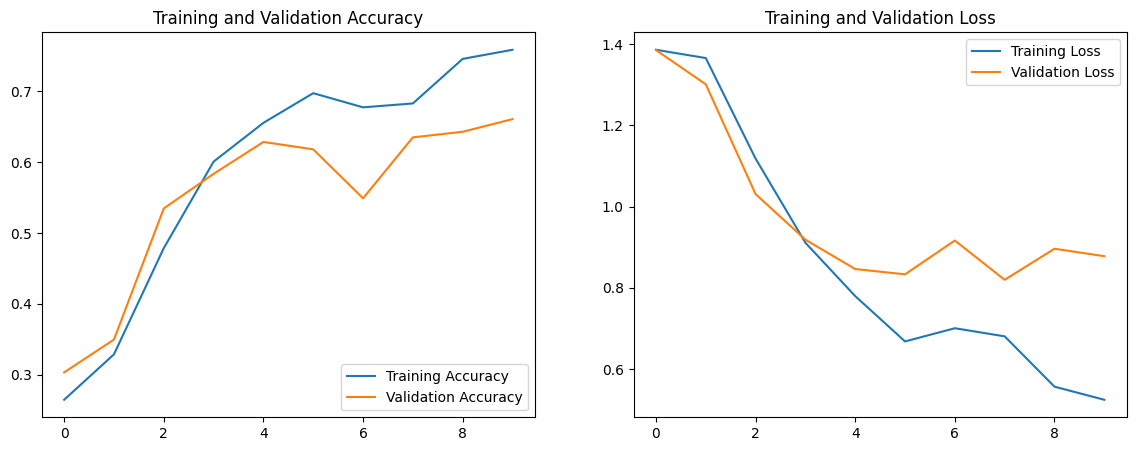

In [39]:
def plot_training_history(history):

    # Retrieve training metrics
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history.get('val_sparse_categorical_accuracy')

    # Retrieve validation metrics if available
    loss_vals = history.history['loss']
    val_loss = history.history.get('val_loss')
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss_vals, label='Training Loss')
    if val_loss:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)
